## Æther: Pipeline


In [14]:
import os
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

## Dataset


In [15]:
class PlagiarismDataset(Dataset):
    """
    PyTorch Dataset implementation for code plagiarism detection

    This class handles pairs of code files, reading them from specific
    directories, tokenizing them together, and preparing them for model input.

    Attributes:
        file_pairs (list): List of tuples containing pairs of files IDS (id1, id2)
        labels (list): List of binary labels (0 for no plagiarism, 1 for plagiarism)
        base_dir (Path): Base directory containing the code files
        tokenizer: HuggingFace tokenizer for encoding code pairs
        max_length (int): Maximum sequence length for tokenization
    """

    def __init__(self, file_pairs, labels, base_dir, tokenizer, max_length=512):
        """
        Initialize the plagiarism dataset.

        Args:
            file_pairs (list): List of tuples containing pairs of file IDs to compare
            labels (list): Corresponding binary labels (0/1) indicating plagiarism
            base_dir (str or Path): Root directory containing the code files
            tokenizer: HuggingFace tokenizer for encoding the code
            max_length (int, optional): Maximum sequence length for tokenization. Defaults to 512.
        """

        self.file_pairs = file_pairs
        self.labels = labels
        self.base_dir = Path(base_dir)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Get the number of code pairs in the dataset.

        Returns:
            int: Number of code pairs
        """

        return len(self.file_pairs)

    def __getitem__(self, idx):
        """
        Get a code pair and its label by index.

        This method:
        1. Retrieves file IDs and label for the specified index
        2. Reads code content from both files
        3. Tokenizes both code samples together
        4. Returns a dictionary with tokenized inputs and label

        Args:
            idx (int): Index of the code pair to retrieve

        Returns:
            dict: Dictionary containing:
                - 'input_ids': Tokenized input IDs
                - 'attention_mask': Attention mask for the tokenized input
                - 'label': Tensor containing the plagiarism label
        """

        id1, id2 = self.file_pairs[idx]
        label = self.labels[idx]

        code1 = self._read_file(id1)
        code2 = self._read_file(id2)

        encoded = self.tokenizer(
            code1,
            code2,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long),
        }

    def _read_file(self, file_id):
        """
        Read a Java code file from the dataset directory.

        The files are identified by their ID and all have .java extension.
        The CSV file contains pairs of IDs indicating which files to compare.

        Args:
            file_id: ID of the Java file to read

        Returns:
            str: Content of the Java code file or empty string if file not found
        """

        path = self.base_dir / f"{file_id}.java"
        if path.exists():
            try:
                return path.read_text(encoding="utf-8")

            except UnicodeDecodeError:
                return path.read_text(encoding="latin-1")

## Model


In [16]:
class PlagiarismModel(nn.Module):
    """
    Neural network model for code plagiarism detection based on CodeBERT embeddings.

    This model utilizes CodeBERT to extract contextual embeddings from pairs of
    code samples, then passes the CLS token representation through a classifier
    network to predict whether the code pair exhibits plagiarism.

    Attributes:
        codebert: Pretrained CodeBERT model for extracting code embeddings
        classifier: Sequential neural network for binary classification
    """

    def __init__(self, model_name):
        """
        Initialize the plagiarism detection model.

        Args:
            model_name (str): Name or path of the pretrained CodeBERT model
                              (e.g., "microsoft/codebert-base")

        Note:
            The model assumes CodeBERT's hidden size is 768 dimensions. If using
            a different pretrained model, this value may need adjustment.
        """

        super(PlagiarismModel, self).__init__()

        self.codebert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),  # Reduce from CodeBERT's 768 dimensions to 256
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 2),
        )

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the model.

        The model processes tokenized code pairs through CodeBERT, extracts the
        CLS token representation (which encodes the relationship between the two
        code samples), and passes it through the classifier to get plagiarism
        prediction logits.

        Args:
            input_ids (torch.Tensor): Tokenized input IDs of code pairs
            attention_mask (torch.Tensor): Attention mask for the input

        Returns:
            torch.Tensor: Logits for binary classification (no plagiarism, plagiarism)
        """

        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]

        return self.classifier(cls_output)

## Detection


In [17]:
class PlagiarismDetection:
    """
    Main class for code plagiarism detection that orchestrates the entire workflow.

    This class handles the complete plagiarism detection pipeline including:
    - Model initialization and configuration
    - Data loading and preprocessing
    - Model training and evaluation
    - Model saving and loading

    Attributes:
        model_name (str): Name or path of the CodeBERT model
        tokenizer: HuggingFace tokenizer for encoding code pairs
        model: The neural network model for plagiarism detection
        device: PyTorch device for computation (CPU or GPU)
    """

    def __init__(self, model_name="microsoft/codebert-base"):
        """
        Initialize the plagiarism detection system.

        Args:
            model_name (str, optional): Pretrained model identifier to use.
                                       Defaults to "microsoft/codebert-base".
        """

        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = PlagiarismModel(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def load_data(self, csv_path, data_dir):
        """
        Load and prepare data for training and testing.

        Reads the CSV file containing code pair IDs and plagiarism labels,
        splits the data into training and test sets, and creates DataLoader
        instances for efficient batch processing.

        Args:
            csv_path (str): Path to the CSV file with columns 'id1', 'id2', 'plagio'
            data_dir (str): Directory containing code files

        Returns:
            tuple: (train_loader, test_loader) - DataLoader instances for training and testing
        """

        df = pd.read_csv(csv_path)

        required_columns = ["id1", "id2", "plagio"]
        missing_columns = [col for col in required_columns if col not in df.columns]

        if missing_columns:
            raise ValueError(
                f"CSV file missing required columns: {missing_columns}. Available columns: {df.columns.tolist()}"
            )

        file_pairs = list(zip(df["id1"], df["id2"]))
        labels = df["plagio"].tolist()

        train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
            file_pairs, labels, test_size=0.3, random_state=42, stratify=labels
        )

        val_pairs, test_pairs, val_labels, test_labels = train_test_split(
            temp_pairs,
            temp_labels,
            test_size=0.67,
            random_state=42,
            stratify=temp_labels,
        )

        train_dataset = PlagiarismDataset(
            train_pairs, train_labels, data_dir, self.tokenizer
        )

        val_dataset = PlagiarismDataset(val_pairs, val_labels, data_dir, self.tokenizer)

        test_dataset = PlagiarismDataset(
            test_pairs, test_labels, data_dir, self.tokenizer
        )

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)
        test_loader = DataLoader(test_dataset, batch_size=16)

        return train_loader, val_loader, test_loader

    def train(self, train_loader, val_loader=None, epochs=3):
        """
        Train the plagiarism detection model.

        Performs training for the specified number of epochs, tracking
        loss and accuracy metrics throughout the process.

        Args:
            train_loader (DataLoader): DataLoader containing training data
            val_loader (DataLoader, optional): DataLoader containing validation data
            epochs (int, optional): Number of training epochs. Defaults to 3.
        """

        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            correct = 0
            total = 0

            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)

                # Forward pass
                optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                # Backward pass
                loss.backward()
                optimizer.step()

                # Track metrics
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate epoch metrics
            epoch_loss = total_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%")

            self.history["train_loss"].append(epoch_loss)
            self.history["train_acc"].append(epoch_acc)

            if val_loader is not None:
                val_loss, val_acc = self._evaluate_epoch(val_loader, criterion)
                print(f"Validation: Loss={val_loss:.4f}, Accuracy={val_acc:.2f}%")
                self.history["val_loss"].append(val_loss)
                self.history["val_acc"].append(val_acc)

        self.plot_history()

    def _evaluate_epoch(self, data_loader, criterion):
        """
        Evaluate model performance for a single epoch.

        Args:
            data_loader (DataLoader): DataLoader to evaluate on
            criterion: Loss function

        Returns:
            tuple: (loss, accuracy) for the epoch
        """

        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate metrics
        epoch_loss = total_loss / len(data_loader)
        epoch_acc = 100 * correct / total

        # Set back to training mode
        self.model.train()

        return epoch_loss, epoch_acc

    def plot_history(self):
        """
        Plot training and validation history.

        Creates a figure with two subplots: loss and accuracy throughout training.
        """

        plt.figure(figsize=(12, 5))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(self.history["train_loss"], label="Training Loss")
        if len(self.history["val_loss"]) > 0:
            plt.plot(self.history["val_loss"], label="Validation Loss")
        plt.title("Loss during Training")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.history["train_acc"], label="Training Accuracy")
        if len(self.history["val_acc"]) > 0:
            plt.plot(self.history["val_acc"], label="Validation Accuracy")
        plt.title("Accuracy during Training")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.tight_layout()
        plt.savefig("training_history.png")
        plt.show()

    def evaluate(self, test_loader):
        """
        Evaluate the model on test data.

        Sets the model to evaluation mode and calculates accuracy on the test set.
        Also generates a confusion matrix and performance graphs.

        Args:
            test_loader (DataLoader): DataLoader containing test data

        Returns:
            float: Accuracy percentage on test data
        """

        self.model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Testing"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["label"].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect predictions and labels for confusion matrix
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")

        # Create and plot confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Non-Plagiarized", "Plagiarized"],
            yticklabels=["Non-Plagiarized", "Plagiarized"],
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()

        # Print classification report
        report = classification_report(
            all_labels, all_preds, target_names=["Non-Plagiarized", "Plagiarized"]
        )
        print("Classification Report:")
        print(report)

        return accuracy

## Execution


In [18]:
detector = PlagiarismDetection()

In [19]:
train_loader, val_loader, test_loader = detector.load_data(
    csv_path="datasets/conplag_labels.csv", data_dir="datasets/conplag_preprocesed"
)

Epoch 1/3: 100%|██████████| 40/40 [08:20<00:00, 12.50s/it]


Epoch 1: Loss=0.5966, Accuracy=71.43%
Validation: Loss=0.5946, Accuracy=72.22%


Epoch 2/3: 100%|██████████| 40/40 [07:57<00:00, 11.95s/it]


Epoch 2: Loss=0.5860, Accuracy=72.37%
Validation: Loss=0.5782, Accuracy=72.22%


Epoch 3/3: 100%|██████████| 40/40 [08:05<00:00, 12.14s/it]


Epoch 3: Loss=0.5572, Accuracy=73.47%
Validation: Loss=0.5644, Accuracy=74.44%


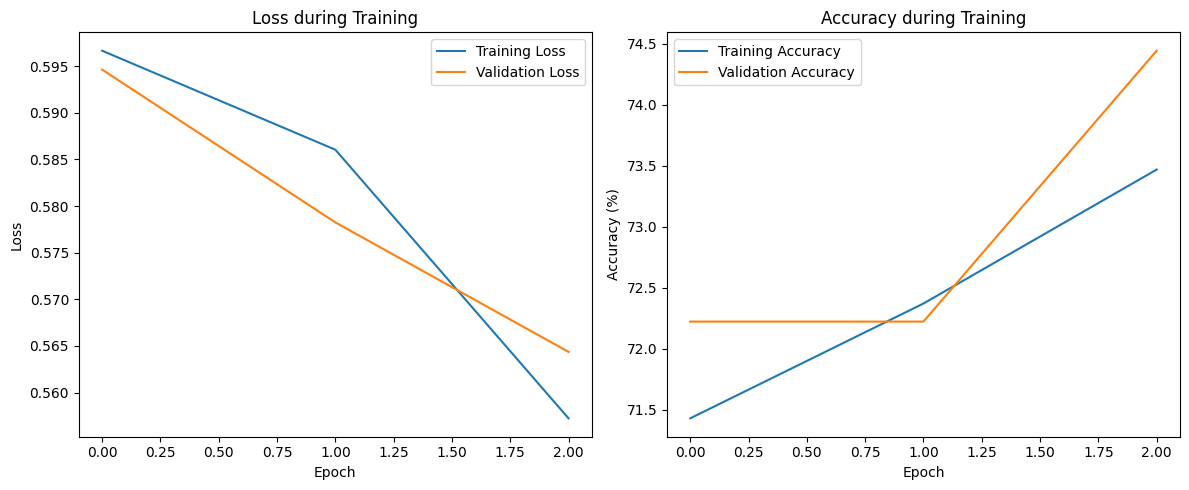

Testing: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Test Accuracy: 77.72%


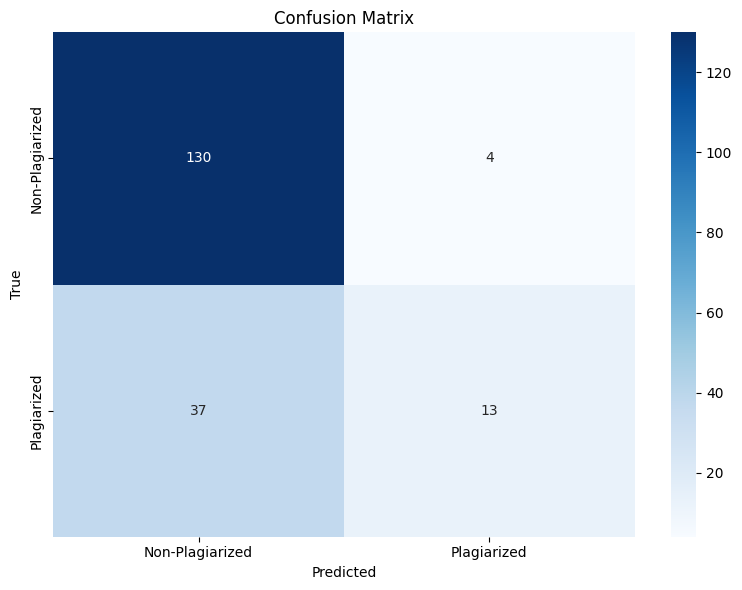

Classification Report:
                 precision    recall  f1-score   support

Non-Plagiarized       0.78      0.97      0.86       134
    Plagiarized       0.76      0.26      0.39        50

       accuracy                           0.78       184
      macro avg       0.77      0.62      0.63       184
   weighted avg       0.77      0.78      0.73       184



In [20]:
detector.train(train_loader, val_loader, epochs=3)
accuracy = detector.evaluate(test_loader)